#### Packages & Load Data

In [77]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import mutual_info_score
from sklearn.preprocessing import StandardScaler
from scipy import stats

In [78]:
file = "database/dfT_result.csv"
fileEX = "database/上市公司內外銷資料.xlsx"
df = pd.read_csv(file, encoding='big5')
dfEX = pd.read_excel(fileEX)

In [79]:
desired_ex = ['代號', '生產值(千元)', '外銷比率％']
dfEX = dfEX[desired_ex]

df = df.merge(dfEX, on='代號', how='outer')
df = df.dropna(subset=['industry_id'])
df['industry_id'] = df['industry_id'].astype(int)
print(df)

       代號  industry_id LEVEL_111            E1   E9  E10  E17   Q4   Q7  Q11  \
0    1101           14        B+  1.000000e+00  2.0  0.0  2.0  2.0  2.0  0.0   
1    1102           14         A  1.000000e+00  2.0  0.0  2.0  1.0  2.0  0.0   
2    1103           14         B  1.000000e+00  1.0  2.0  2.0  0.0  0.0  0.0   
3    1104           14        B+  1.000000e+00  0.0  0.0  2.0  0.0  0.0  0.0   
4    1108           14         B  0.000000e+00  0.0  0.0  2.0  1.0  1.0  0.0   
..    ...          ...       ...           ...  ...  ...  ...  ...  ...  ...   
704  9938            3        B+  0.000000e+00  0.0  0.0  2.0  0.0  0.0  0.0   
705  9939           15        B+  1.000000e+00  0.0  0.0  2.0  0.0  0.0  0.0   
706  9942           22         B -2.147484e+09  0.0  0.0  2.0  0.0  0.0  0.0   
707  9944            3        B- -2.147484e+09  2.0  0.0  2.0  0.0  0.0  0.0   
708  9958           16         B -2.147484e+09  2.0  0.0  2.0  0.0  0.0  0.0   

     ...  S3_topic_score S4_topic_score

In [80]:
df['外銷比率％'].describe()

count    705.000000
mean      63.067518
std       34.519705
min       -4.800000
25%       33.950000
50%       77.090000
75%       92.470000
max      100.000000
Name: 外銷比率％, dtype: float64

In [81]:
df['外銷比重'] = pd.cut(df['外銷比率％'], bins=[0, 0.0001, 10, 20, 30, 40, 50, 100], include_lowest=True, 
       labels = ['0%(無外銷)', '外銷比例超過0%~10%', '外銷比例超過10%~20%', '外銷比例超過20%~30%', '外銷比例超過30%~40%', '外銷比例超過40%~50%', '外銷比例超過50%'])
df.groupby('外銷比重')['外銷比重'].count()

外銷比重
0%(無外銷)           31
外銷比例超過0%~10%      73
外銷比例超過10%~20%     24
外銷比例超過20%~30%     35
外銷比例超過30%~40%     26
外銷比例超過40%~50%     37
外銷比例超過50%        478
Name: 外銷比重, dtype: int64

In [82]:
df['生產值(千元)'].describe()

count    6.790000e+02
mean     2.979282e+07
std      1.709841e+08
min      3.586000e+03
25%      1.605310e+06
50%      3.929906e+06
75%      1.198619e+07
max      3.721130e+09
Name: 生產值(千元), dtype: float64

In [83]:
df['生產值(元)'] = pd.cut(df['生產值(千元)'], bins=[0, 100000, 200000, 500000, 1000000, 2000000, 5000000, 10000000, 20000000, 50000000, 100000000, 4000000000], include_lowest=True, 
       labels = ['1億以下', '1億~2億', '2億~5億', '5億~10億', '10億~20億', '20億~50億', '50億~100億', '100億~200億', '200億~500億', '500億~1000億', '大於1000億'])
df.groupby('生產值(元)')['生產值(元)'].count()

生產值(元)
1億以下           11
1億~2億           7
2億~5億          39
5億~10億         48
10億~20億       102
20億~50億       166
50億~100億      105
100億~200億      86
200億~500億      55
500億~1000億     30
大於1000億        30
Name: 生產值(元), dtype: int64

##### 依產業別(industry_id)分析

c:\Users\mayda\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


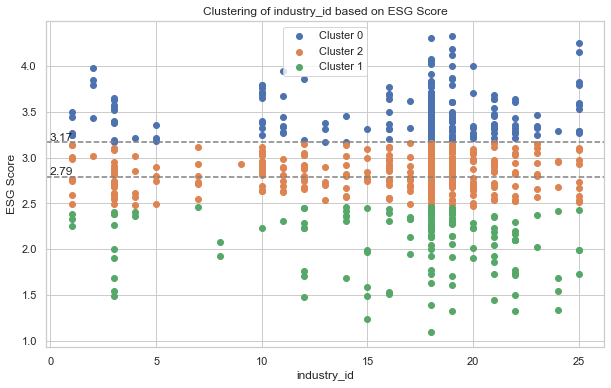

[3.48781095 2.09433824 2.84354301]


In [84]:
df2 = df[['industry_id','ESG_score']].copy()

numeric_df = df[['ESG_score']]  # Selecting only the ESG_score column for clustering

# Perform K-means clustering
kmeans = KMeans(n_clusters=3)  # Can adjust the number of clusters as needed
kmeans.fit(numeric_df)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_
cluster_edges = [(centroids[0]+centroids[i+1])/2 for i in range(len(centroids)-1)]

# Add cluster labels to the DataFrame
df2['cluster'] = labels

# Plotting
plt.figure(figsize=(10, 6))

for i, edge in enumerate(cluster_edges):
    plt.axhline(y=edge[0], color='gray', linestyle='--')
    plt.text(0.5, edge[0], f'{edge[0]:.2f}', ha='center', va='bottom')

for cluster_label in df2['cluster'].unique():
    cluster_data = df2[df2['cluster'] == cluster_label]
    plt.scatter(cluster_data['industry_id'], cluster_data['ESG_score'], label=f'Cluster {cluster_label}')

plt.xlabel('industry_id')
plt.ylabel('ESG Score')
plt.title('Clustering of industry_id based on ESG Score')
plt.legend()
plt.show()

print(centroids[: ,0])

In [85]:
# Calculate the count of factories in each industry
industry_counts = df.groupby(['industry_id']).size().reset_index(name='樣本數')

# Calculate the mean scores for each industry
industry_scores = df.groupby(['industry_id']).agg({
    'E_score': 'mean',
    'S_score': 'mean',
    'G_score': 'mean',
    'ESG_score': 'mean'
}).reset_index()

# Merge counts and scores into a new DataFrame
industry_summary = pd.merge(industry_counts, industry_scores, on='industry_id')
industry_summary = industry_summary.round(4)
industry_summary.to_csv("上市公司依產業別.csv", encoding='big5')
print(industry_summary)

    industry_id  樣本數  E_score  S_score  G_score  ESG_score
0             1   17   2.2941   4.0353   2.7647     2.8988
1             2    5   2.9600   4.0800   4.0000     3.6144
2             3   38   1.8421   3.5211   3.2368     2.7639
3             4    8   1.9000   3.4750   3.0000     2.6897
4             5    7   2.2571   3.7714   3.1429     2.9546
5             7    7   1.6857   3.7143   3.2500     2.7560
6             8    2   2.0000   1.3000   2.5000     2.0050
7             9    1   1.6000   4.2000   3.5000     2.9340
8            10   30   2.6533   4.0600   2.9917     3.1268
9            11   16   2.5750   3.6125   3.1875     3.0549
10           12   22   1.9636   3.5727   2.7500     2.6490
11           13    7   2.4000   3.8857   2.9286     2.9617
12           14   16   2.1125   3.3625   2.7969     2.6714
13           15   13   1.7692   2.8769   2.7692     2.4062
14           16   32   2.2000   3.6938   3.1406     2.9121
15           17   19   2.1474   3.2632   2.8816     2.69

##### 依規模別分析

In [86]:
# Calculate the count of factories in each size level
size_counts = df.groupby(['生產值(元)']).size().reset_index(name='樣本數')

# Calculate the mean scores for each company size
size_scores = df.groupby(['生產值(元)']).agg({
    'E_score': 'mean',
    'S_score': 'mean',
    'G_score': 'mean',
    'ESG_score': 'mean'
}).reset_index()

# Merge counts and scores into a new DataFrame
size_summary = pd.merge(size_counts, size_scores, on='生產值(元)')
size_summary = size_summary.round(4)
size_summary.to_csv("上市公司依規模.csv", encoding='big5')
print(size_summary)

        生產值(元)  樣本數  E_score  S_score  G_score  ESG_score
0         1億以下   11   2.3273   3.8727   3.1136     2.9967
1        1億~2億    7   2.0571   2.9429   2.5714     2.4637
2        2億~5億   39   2.1744   3.7692   3.1218     2.9142
3       5億~10億   48   1.9958   3.4000   3.0156     2.7140
4      10億~20億  102   2.1784   3.6039   3.0539     2.8500
5      20億~50億  166   2.1627   3.6867   3.0377     2.8587
6     50億~100億  105   2.2267   3.5448   2.9786     2.8269
7    100億~200億   86   2.0860   3.8349   3.2674     2.9486
8    200億~500億   55   2.1418   3.8909   3.2409     2.9748
9   500億~1000億   30   2.2800   3.9800   3.3833     3.1022
10     大於1000億   30   2.6933   3.8933   3.3083     3.2147


##### 依外銷比重

In [87]:
# Calculate the count of factories in each export ratio
export_counts = df.groupby(['外銷比重']).size().reset_index(name='樣本數')

# Calculate the mean scores for each company export ratio
export_scores = df.groupby(['外銷比重']).agg({
    'E_score': 'mean',
    'S_score': 'mean',
    'G_score': 'mean',
    'ESG_score': 'mean'
}).reset_index()

# Merge counts and scores into a new DataFrame
export_summary = pd.merge(export_counts, export_scores, on='外銷比重')
export_summary = export_summary.round(4)
export_summary.to_csv("上市公司依外銷比重.csv", encoding='big5')
print(export_summary)

            外銷比重  樣本數  E_score  S_score  G_score  ESG_score
0        0%(無外銷)   31   2.1419   3.5032   3.0000     2.7912
1   外銷比例超過0%~10%   73   2.1671   3.8466   3.0822     2.9164
2  外銷比例超過10%~20%   24   2.1833   3.5833   3.1875     2.8948
3  外銷比例超過20%~30%   35   2.0057   3.4286   3.0000     2.7194
4  外銷比例超過30%~40%   26   2.1462   3.8385   3.1538     2.9320
5  外銷比例超過40%~50%   37   2.4865   3.9459   3.1486     3.0897
6      外銷比例超過50%  478   2.1485   3.6628   3.1182     2.8762


In [108]:
def count_company_exceeding_export_ratio(df, export_ratio='外銷比例超過50%', column_name='industry_id'):
    # Filter the DataFrame to include only rows where the export ratio exceeds 50%
    df_filtered = df[df['外銷比重'] == export_ratio]
    
    # Use the count_factory_by_industry function to count the number of companies in each industry
    count_by_industry = count_factory_by_industry(df_filtered, column_name)
    
    return count_by_industry

# Call the function to count the number of companies in each industry with export ratio exceeding 50%
company_count_by_industry = count_company_exceeding_export_ratio(df)

print(company_count_by_industry)


industry_id
18    179
19     93
21     32
22     24
10     19
3      18
17     17
25     14
20     10
23      9
12      9
15      8
16      7
11      7
4       7
24      7
13      6
5       5
7       3
1       2
14      1
8       1
Name: 代號, dtype: int64


##### 整體製造業

In [134]:
mean_E = df['E_score'].mean() 
mean_S = df['S_score'].mean() 
mean_G = df['G_score'].mean() 
mean_ESG = df['ESG_score'].mean() 

In [135]:
print(mean_E, mean_S, mean_G, mean_ESG)

2.169534555712271 3.676163610719323 3.103667136812412 2.8824795486600845


In [90]:
df['ESG_score'].describe()

count    709.000000
mean       2.882480
std        0.530766
min        1.090000
25%        2.590000
50%        2.902000
75%        3.218000
max        4.330000
Name: ESG_score, dtype: float64

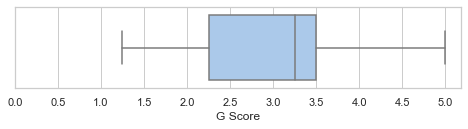

In [91]:
# Set the style of the seaborn plots
sns.set(style="whitegrid")

# Draw the box plot of ESG score
plt.figure(figsize=(8, 1.5))
sns.boxplot(x='G_score', data=df, palette="pastel")
plt.xticks(np.arange(0, 5.5, 0.5))
plt.xlabel('G Score')
plt.show()

#### 各種分析

In [103]:
def get_top_bottom_percentiles(df, column_name, top_pct=15, bottom_pct=25):

    # Sort the DataFrame by ESG scores
    df_sorted = df.sort_values(by='ESG_score', ascending=False)
    num_factories = len(df_sorted)

    # Select the top 10 and bottom 10 factories
    top_n = int(num_factories * (top_pct /100))
    bottom_n = int(num_factories * (bottom_pct /100))
    total_rank = num_factories

    df_sorted['Rank'] = df_sorted.index.map({
        i: rank if i < top_n else total_rank - rank - 4
        for i, rank in enumerate(range(1, top_n+1))
    })

    top_indices = df_sorted.index[:top_n]
    bottom_indices = df_sorted.index[-bottom_n:]
    return top_indices, bottom_indices

def count_factory_by_industry(df, column_name='industry_id'):
    count_factory = df.groupby(column_name)['代號'].count()
    count_factory = count_factory.sort_values(ascending=False)
    return count_factory

def perc_factory_by_industry(df, df_specific, column_name='industry_id'):
    all_factory = df.groupby(column_name)['代號'].count()
    specific_factory = df_specific.groupby(column_name)['代號'].count()
    perc_factory = (specific_factory / all_factory).sort_values(ascending=False)
    return perc_factory

def count_export_by_industry(df, column_name='industry_id'):
    export_factory = df.groupby(column_name)['代號'].count()
    export_factory = export_factory.sort_values(ascending=False)
    return export_factory

In [104]:
top_indices, bottom_indices = get_top_bottom_percentiles(df, 'ESG_score')
top_factories = df.loc[top_indices]
bottom_factories = df.loc[bottom_indices]

top_factory_counts = count_factory_by_industry(top_factories)
top_factory_df = pd.Series(perc_factory_by_industry(df, top_factories)).to_frame(name="Top Factories")

bottom_factory_counts = count_factory_by_industry(bottom_factories)
bottom_factory_df = pd.Series(perc_factory_by_industry(df, bottom_factories)).to_frame(name="Top Factories")

##### CR4

In [126]:
industry_market_value = {
    1: (867075266),  # id=1, 食品製造業, 食品與飲料
    2: (183844682),  # id=2, 飲料製造業/菸草製造業, 食品與飲料
    3: (378790046),  # id=3, 紡織業, 消費品
    4: (205922271),  # id=4, 成衣及服飾品製造業, 消費品
    5: (148527616),  # id=5, 皮革、毛皮及其製品製造業, 消費品
    6: (61113421),
    7: (280872538),  # id=7, 
    8: (130740587),  # id=8, 印刷及資料儲存媒體複製業, 服務
    9: (1556952298),  # id=9, 石油及煤製品製造業, 提煉與礦產加工
    10: (2224246009),  # Industry 10 weights
    11: (379056049),  # id=11, 其他化學製品製造業, 資源轉化
    12: (148591221),  # id=12, 藥品及醫用化學製品製造業, 醫療保健
    13: (153565112),  # Industry 13 weights
    14: (594326636),  # Industry 14 weights
    15: (480016392),  # Industry 15 weights
    16: (1725018215),  # id=16, 基本金屬製造業, 提煉與礦產加工
    17: (1678944610),  # id=17, 金屬製品製造業, 提煉與礦產加工
    18: (7674242135),  # Industry 18 weights
    19: (11259568717),  # Industry 19 weights
    20: (1037115540),  # Industry 20 weights
    21: (1322745941),  # id=21, 機械設備製造業, 資源轉化
    22: (601288482),  # id=22, 汽車及其零件製造業, 運輸
    23: (553461710),  # id=23, 其他運輸工具及其零件製造業, 運輸
    24: (111858737),  # id=24, 家具製造業, 消費品
    25: (377673747)   # id=25, 其他製造業, 醫療保健
}

In [133]:
def calculate_market_concentration(industry_market_values, df, industry_column='industry_id', market_value_column='生產值(千元)', top_firms=4):
    # Create a new DataFrame to hold the total market values for each industry
    industry_market_df = pd.DataFrame.from_dict(industry_market_values, orient='index', columns=['total_market_value'])
    industry_market_df.reset_index(inplace=True)
    industry_market_df.rename(columns={'index': industry_column}, inplace=True)
    
    # Merge the total market values DataFrame with the original DataFrame on the industry column
    merged_df = pd.merge(df, industry_market_df, on=industry_column)

    # Calculate the market share of each company within its industry
    merged_df['market_share'] = merged_df[market_value_column] / merged_df['total_market_value']

    # Sort the companies within each industry based on their market share
    sorted_df = merged_df.sort_values(by=[industry_column, 'market_share'], ascending=[True, False])
    sorted_df.to_csv("cr4.csv", encoding = 'big5')
    # Group by industry and sum the market shares of the top firms
    cr = sorted_df.groupby(industry_column)['market_share'].apply(lambda x: x.head(top_firms).sum())
    
    return cr

# Calculate market concentration based on CR4 for each industry
market_concentration = calculate_market_concentration(industry_market_value, df)

print(market_concentration)


industry_id
1     0.228015
2     0.364355
3     0.937659
4     0.439118
5     1.529677
7     0.708794
8     0.009568
9     0.507046
10    0.524564
11    0.140617
12    0.088510
13    0.696052
14    0.342445
15    0.115109
16    0.440211
17    0.028292
18    0.218717
19    0.618448
20    0.193971
21    0.048864
22    0.125748
23    0.294493
24    0.303049
25    0.100808
Name: market_share, dtype: float64
